# Forest Cover Type Prediction 

**The goal of the Project**: to predict seven different cover types in four different wilderness areas of the Roosevelt National Forest of Northern Colorado with the best accuracy.



# Sections

- [1. EDA](#1)
- [2. Feature Engineering](#2)
- [3. Building Model](#3)
    - [3.1 K-Nearest Neighbors](#4)
    - [3.2 Decision Tree](#5)
    - [3.3 Random Forest](#6)
    - [3.4 Extra Tree](#7)
    - [3.5 PCA](#8)

In [49]:
# load the package
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint # data better printer

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold #cross validation

# for feature scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# tree models
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#hyperparameter search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#model validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve,confusion_matrix, accuracy_score
import sklearn.metrics as metrics
from subprocess import call
from IPython.display import Image

# for plot the tree
from sklearn.tree import plot_tree

# 1. EDA  <a id ="1"></a>

- ## Check for Anomalies & Outliers:

In [2]:
# read the data
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Id                                  15120 non-null  int64
 1   Elevation                           15120 non-null  int64
 2   Aspect                              15120 non-null  int64
 3   Slope                               15120 non-null  int64
 4   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 5   Vertical_Distance_To_Hydrology      15120 non-null  int64
 6   Horizontal_Distance_To_Roadways     15120 non-null  int64
 7   Hillshade_9am                       15120 non-null  int64
 8   Hillshade_Noon                      15120 non-null  int64
 9   Hillshade_3pm                       15120 non-null  int64
 10  Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 11  Wilderness_Area1                    15120 non-null  int64
 12  Wild

- Training dataset has 15120 entries and 56 columns with id. Dataset has no missing values and every column has a numeric (float or integer) data type.
- Cover_Type is our target column. Wilderness_Area and Soil_Type columns might have binary values (0,1).



- ## Check Outliers

In [4]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [5]:
# loop through all columns to see if there are any outliers
for column in train.columns:
    if outlier_function(train, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(train, column)[2], column))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 7 outliers in Hillshade_9am
There are 20 outliers in Hillshade_Noon
There are 132 outliers in Horizontal_Distance_To_Fire_Points
There are 3597 outliers in Wilderness_Area1
There are 499 outliers in Wilderness_Area2
There are 355 outliers in Soil_Type1
There are 623 outliers in Soil_Type2
There are 962 outliers in Soil_Type3
There are 843 outliers in Soil_Type4
There are 165 outliers in Soil_Type5
There are 650 outliers in Soil_Type6
There are 1 outliers in Soil_Type8
There are 10 outliers in Soil_Type9
There are 2142 outliers in Soil_Type10
There are 406 outliers in Soil_Type11
There are 227 outliers in Soil_Type12
There are 476 outliers in Soil_Type13
There are 169 outliers in Soil_Type14
There are 114 outliers in Soil_Type16
There are 612 outliers in Soil_Type17
There are 60 outliers in Soil_Type18
There a

- ## Check the important correlations between variables 

In [6]:
# Calculates pearson co-efficient for all combinations
data_corr = train.corr()
#get the names of all the columns
cols=train.columns 
# Set the threshold to select only only highly correlated attributes
threshold = 0.5
# List of pairs along with correlation above threshold
corr_list = []

for i in range(len(data_corr)):
    for j in range(1,len(data_corr)):
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
sorted_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in sorted_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

Elevation and Wilderness_Area4 = -0.78
Wilderness_Area4 and Elevation = -0.78
Hillshade_9am and Hillshade_3pm = -0.78
Hillshade_3pm and Hillshade_9am = -0.78
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.65
Vertical_Distance_To_Hydrology and Horizontal_Distance_To_Hydrology = 0.65
Aspect and Hillshade_3pm = 0.64
Hillshade_3pm and Aspect = 0.64
Hillshade_Noon and Hillshade_3pm = 0.61
Hillshade_3pm and Hillshade_Noon = 0.61
Slope and Hillshade_Noon = -0.61
Hillshade_Noon and Slope = -0.61
Aspect and Hillshade_9am = -0.59
Hillshade_9am and Aspect = -0.59
Elevation and Horizontal_Distance_To_Roadways = 0.58
Horizontal_Distance_To_Roadways and Elevation = 0.58
Wilderness_Area3 and Wilderness_Area4 = -0.57
Wilderness_Area4 and Wilderness_Area3 = -0.57
Wilderness_Area1 and Soil_Type29 = 0.55
Soil_Type29 and Wilderness_Area1 = 0.55


- ## Feature: Wilderness_Area, Soil_Type 

In [7]:
columns_check=[column for column in train.columns if ("Wilderness" in column)|("Soil" in column)]
# variables in each feature
for column in columns_check:
    uniques = sorted(train[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

Wilderness_Area1         2	 [0, 1]
Wilderness_Area2         2	 [0, 1]
Wilderness_Area3         2	 [0, 1]
Wilderness_Area4         2	 [0, 1]
Soil_Type1               2	 [0, 1]
Soil_Type2               2	 [0, 1]
Soil_Type3               2	 [0, 1]
Soil_Type4               2	 [0, 1]
Soil_Type5               2	 [0, 1]
Soil_Type6               2	 [0, 1]
Soil_Type7               1	 [0]
Soil_Type8               2	 [0, 1]
Soil_Type9               2	 [0, 1]
Soil_Type10              2	 [0, 1]
Soil_Type11              2	 [0, 1]
Soil_Type12              2	 [0, 1]
Soil_Type13              2	 [0, 1]
Soil_Type14              2	 [0, 1]
Soil_Type15              1	 [0]
Soil_Type16              2	 [0, 1]
Soil_Type17              2	 [0, 1]
Soil_Type18              2	 [0, 1]
Soil_Type19              2	 [0, 1]
Soil_Type20              2	 [0, 1]
Soil_Type21              2	 [0, 1]
Soil_Type22              2	 [0, 1]
Soil_Type23              2	 [0, 1]
Soil_Type24              2	 [0, 1]
Soil_Type25              2

Wilderness_Area & Soil_Type are binary variables, Soil_Type7 & Soil_Type15 only include value of 0

- ## Feature: cover_type

Text(0.5, 1.0, 'Distribution of Cover_Types')

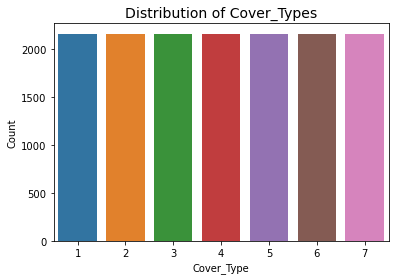

In [8]:
g=sns.countplot(x='Cover_Type',data=train)

# set title, legends and labels
plt.xlabel("Cover_Type")
plt.ylabel("Count")
plt.title("Distribution of Cover_Types", size=14)

Distribution of cover types shows perfect uniform distribution.



- ## Feature: Cover_Type & Wilderness_Areas

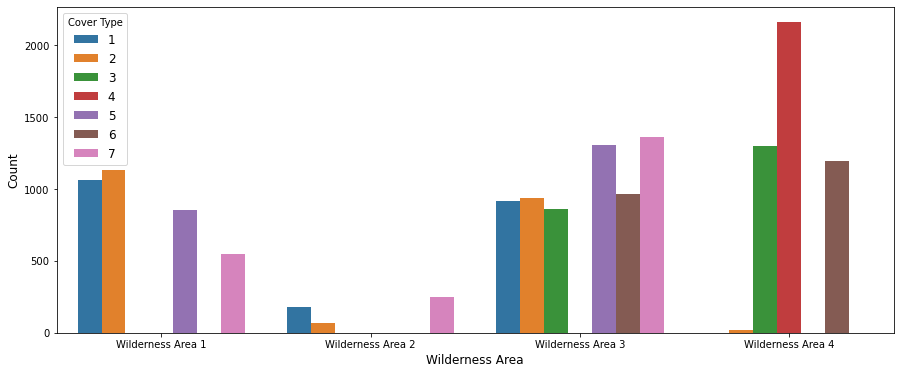

In [9]:
## Reverse One hot encoding to get a column for the Wilderness area
train.loc[train["Wilderness_Area1"]==1,"Wilderness_Area"] = "Wilderness Area 1"
train.loc[train["Wilderness_Area2"]==1,"Wilderness_Area"] = "Wilderness Area 2"
train.loc[train["Wilderness_Area3"]==1,"Wilderness_Area"] = "Wilderness Area 3"
train.loc[train["Wilderness_Area4"]==1,"Wilderness_Area"] = "Wilderness Area 4"
## plot
plt.figure(figsize=(15,6))   
order = ["Wilderness Area 1","Wilderness Area 2","Wilderness Area 3","Wilderness Area 4"]
ax = sns.countplot(x= "Wilderness_Area", hue = "Cover_Type", data = train, order=order)
ax.set_xlabel("Wilderness Area",fontsize=12)
ax.set_ylabel("Count",fontsize=12)
plt.legend(title="Cover Type", loc='upper left',fontsize=12)
plt.show()

some cover types only belong specific wilderness areas, in this case wilderness areas could be a significant variables in the predictive model.

- ## Feature: Other continuous variables

Text(0, 0.5, 'Horizontal Distance To Roadways')

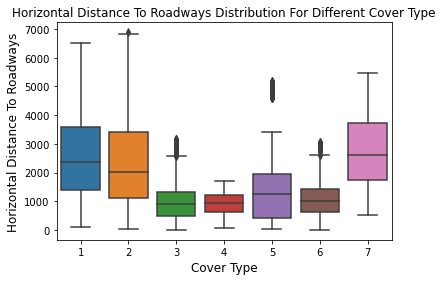

In [10]:
ax = sns.boxplot(y=train['Horizontal_Distance_To_Roadways'], x=train['Cover_Type'])
ax.set_title('Horizontal Distance To Roadways Distribution For Different Cover Type',fontsize=12)
ax.set_xlabel("Cover Type",fontsize=12)
ax.set_ylabel("Horizontal Distance To Roadways",fontsize=12)

Text(0, 0.5, 'Aspect')

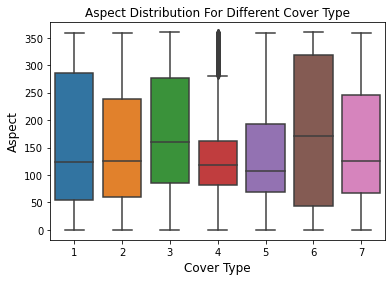

In [11]:
ax=sns.boxplot(y=train['Aspect'], x=train['Cover_Type'])
ax.set_title('Aspect Distribution For Different Cover Type',fontsize=12)
ax.set_xlabel("Cover Type",fontsize=12)
ax.set_ylabel("Aspect",fontsize=12)

Cover Type 4 "Cottonwood/Willow" has long tail distribution for "Aspect"

Text(20.200000000000003, 0.5, 'Elevation')

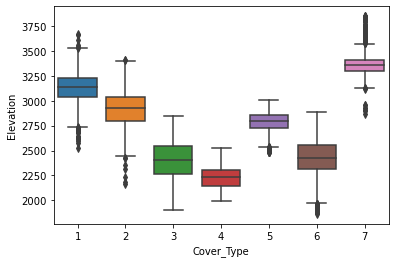

In [12]:
sns.boxplot(y=train['Elevation'], x=train['Cover_Type'])
ax.set_title('Elevation Distribution For Different Cover Type',fontsize=12)
ax.set_xlabel("Cover Type",fontsize=12)
ax.set_ylabel("Elevation",fontsize=12)

# 2. Feature Engineering <a id ="2"></a>

## 2.1  Euclidian distance to Hydrology

Combine Horizontal_Distance_To_Hydrology & Vertical_Distance_To_Hydrology

In [13]:
train['Euclidian_Distance_To_Hydrology']= (train['Horizontal_Distance_To_Hydrology']**2 + train['Vertical_Distance_To_Hydrology']**2)**0.5

In [14]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Wilderness_Area,Euclidian_Distance_To_Hydrology
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,5,Wilderness Area 1,258.000000
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,5,Wilderness Area 1,212.084889
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,2,Wilderness Area 1,275.769832
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,2,Wilderness Area 1,269.235956
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,5,Wilderness Area 1,153.003268


<AxesSubplot:xlabel='Cover_Type', ylabel='Euclidian_Distance_To_Hydrology'>

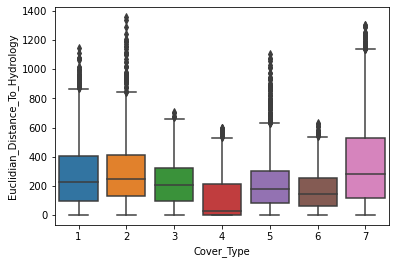

In [15]:
sns.boxplot(y=train["Euclidian_Distance_To_Hydrology"], x=train["Cover_Type"])

**Learn from Kevin's notebook to make the baseline dataset same for group presentation**

In [16]:
def pipeline(df, version=0):
    df_n = df.copy()
    df_n.drop(columns=['Id'],inplace=True)
    df_n = df_n.astype({c:'bool' for c in df_n.columns if "Soil_Type" in c or "Wilderness_Area" in c})
    if version >= 1: 
        col_normalize = ['Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology', 
                     'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
                     'Horizontal_Distance_To_Roadways']
        df_n['log_Horizontal_Distance_To_Roadways'] = np.log(df_n['Horizontal_Distance_To_Roadways']+1)
        df_n['log_Horizontal_Distance_To_Fire_Points'] = np.log(df_n['Horizontal_Distance_To_Fire_Points']+1)
        df_n[col_normalize] = normalize(df_n[col_normalize])
        df_n.drop(columns=['Soil_Type7'],inplace=True)
    if version >= 2: # 0.8964947089947091
        df_n['sq_Elevation'] = np.power(df['Elevation'],1.5)
        df_n.drop(columns='Aspect',inplace=True)
        df_n['norm_aspect'] = df_train.Aspect.map(lambda x: x-180 if x > 180 else x+180) # np.abs(df.Aspect - 180)
        df_n['atan_aspect'] = np.arctan(df_n.norm_aspect)
    if version >= 3: # 0.9104497354497356
        df_n['Vertical_Distance_To_Hydrology'] = np.abs(df_n.Vertical_Distance_To_Hydrology)
        df_n['E-VH'] = df_train.Elevation - df_train.Vertical_Distance_To_Hydrology * .9 
        df_n['E-HH'] = df_train.Elevation - df_train.Horizontal_Distance_To_Hydrology * .5
        
        df_n['F+R'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Roadways) ** 2
        df_n['F+H'] = (df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology) ** 0.3
        df_n['H+R'] = (df_train.Horizontal_Distance_To_Hydrology + df_train.Horizontal_Distance_To_Roadways)
        
        df_n['abs_H-R'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Roadways)) 
        df_n['abs_H-F'] = (np.abs(df_train.Horizontal_Distance_To_Hydrology - df_train.Horizontal_Distance_To_Fire_Points)) 
        df_n['abs_F-R'] = (np.abs(df_train.Horizontal_Distance_To_Fire_Points - df_train.Horizontal_Distance_To_Roadways)) 
    return df_n

In [17]:
df_train = pd.read_csv('train.csv')

In [18]:
df_train_c=pipeline(df_train, version=3)

In [19]:
df_train_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 66 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Elevation                               15120 non-null  int64  
 1   Slope                                   15120 non-null  float64
 2   Horizontal_Distance_To_Hydrology        15120 non-null  float64
 3   Vertical_Distance_To_Hydrology          15120 non-null  float64
 4   Horizontal_Distance_To_Roadways         15120 non-null  float64
 5   Hillshade_9am                           15120 non-null  float64
 6   Hillshade_Noon                          15120 non-null  float64
 7   Hillshade_3pm                           15120 non-null  float64
 8   Horizontal_Distance_To_Fire_Points      15120 non-null  float64
 9   Wilderness_Area1                        15120 non-null  bool   
 10  Wilderness_Area2                        15120 non-null  bo

# 3. Building Model <a id ="3"></a>

### Seperate labels from features in the training set

In [20]:
train_feature=train.drop(['Cover_Type','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Id','Wilderness_Area'],axis=1)
train_label=train['Cover_Type']

### Split training set as training and validation set

In [21]:
X_train, X_dev, y_train, y_dev = train_test_split(train_feature, train_label, test_size=0.2, random_state=1)

## 3.1 K-Nearest Neighbors <a id ="4"></a>

### 3.1.1 Feature Scaling

> KNN chooses the k closest neighbors and then based on these neighbors, assigns a class (for classification problems) or predicts a value (for regression problems) for a new observation. K-Means clusters the similar points together. The similarity here is defined by the distance between the points. Lesser the distance between the points, more is the similarity and vice versa. **Here feature scaling helps to weigh all the features equally.**

### 3.1.1.1 First Rescaling uses Standard Scaling 

>One approach to data scaling involves calculating the mean and standard deviation of each variable and using these values to scale the values to have a mean of zero and a standard deviation of one, a so-called “standard normal” probability distribution. This process is called standardization and is most useful when input variables have a Gaussian probability distribution.

In [22]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_dev_scaled = sc.fit_transform(X_dev)

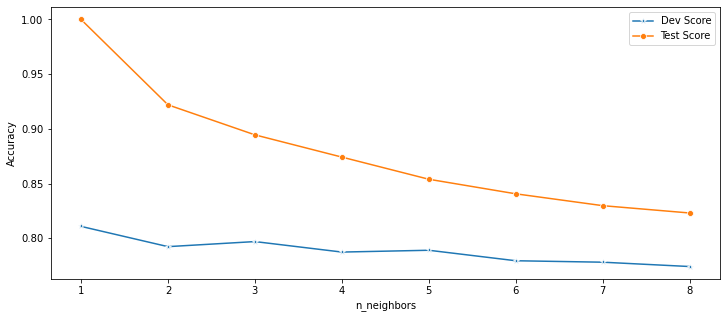

In [23]:
# find the best number of neighbors
n_neighbors=np.arange(1,9)
train_score = np.empty(len(n_neighbors)) 
dev_score = np.empty(len(n_neighbors)) 

# iterate the list
for index,neighbor in enumerate(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbor) 
    knn.fit(X_train_scaled, y_train) 
    # compute training and test data accuracy
    train_score[index] = knn.score(X_train_scaled, y_train) 
    dev_score[index] = knn.score(X_dev_scaled, y_dev) 

# Generate plot 
plt.figure(figsize=(12,5))
p = sns.lineplot(n_neighbors,dev_score,marker='*',label='Dev Score')
p = sns.lineplot(n_neighbors,train_score,marker='o',label='Test Score')   
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [24]:
max_dev_score = max(dev_score)
max_dev_score_index=[i for i, v in enumerate(dev_score) if v == max_dev_score]
print('Max test score {} % and k = {}'.format(max_dev_score*100,list(map(lambda x: x+1, max_dev_score_index))))

Max test score 81.08465608465607 % and k = [1]


### 3.1.1.2 Using Robust Scaling to handle the presences of outliers using Robust Scaling to handle the presences of outliers

> One approach to standardizing input variables in the presence of outliers is to ignore the outliers from the calculation of the mean and standard deviation, then use the calculated values to scale the variable. This is called robust standardization or robust data scaling.

In [25]:
robustsc = RobustScaler()
X_train_scaled_r = robustsc.fit_transform(X_train)
X_dev_scaled_r = robustsc.fit_transform(X_dev)

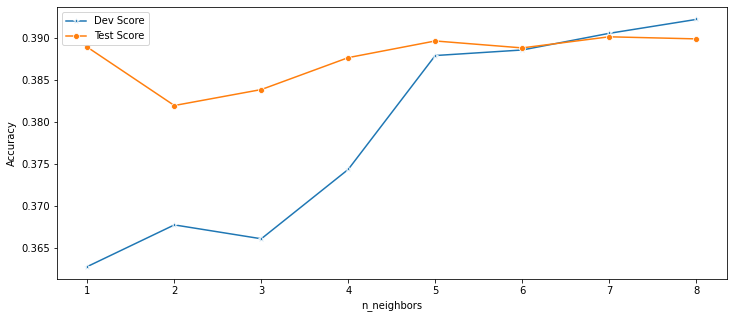

In [26]:
# find the best number of neighbors
n_neighbors=np.arange(1,9)
train_score = np.empty(len(n_neighbors)) 
dev_score = np.empty(len(n_neighbors)) 

# iterate the list
for index,neighbor in enumerate(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbor) 
    knn.fit(X_train_scaled, y_train) 
    # compute training and test data accuracy
    train_score[index] = knn.score(X_train_scaled_r, y_train) 
    dev_score[index] = knn.score(X_dev_scaled_r, y_dev) 

# Generate plot 
plt.figure(figsize=(12,5))
p = sns.lineplot(n_neighbors,dev_score,marker='*',label='Dev Score')
p = sns.lineplot(n_neighbors,train_score,marker='o',label='Test Score')   
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy') 
plt.show() 

In [27]:
max_dev_score = max(dev_score)
max_dev_score_index=[i for i, v in enumerate(dev_score) if v == max_dev_score]
print('Max test score {} % and k = {}'.format(max_dev_score*100,list(map(lambda x: x+1, max_dev_score_index))))

Max test score 39.21957671957672 % and k = [8]


- KNN achieve the best performance, accuracy of 81.08%  with K = 1
- With RobustScaler, the accuracy is under Standard Scaler.

## 3.2 Decision Tree  <a id ="5"></a>


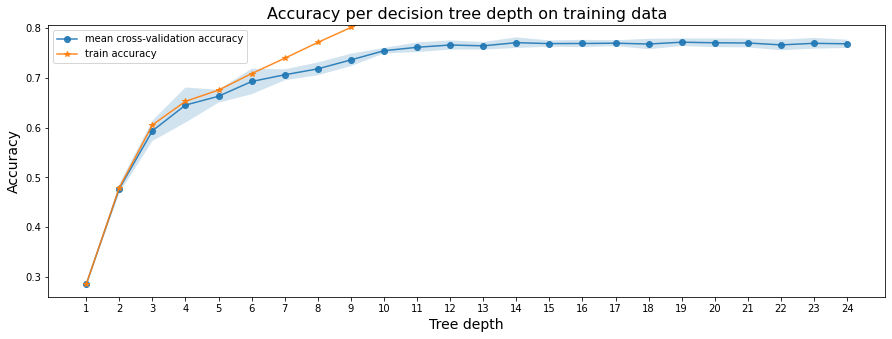

In [28]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [29]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-19 tree achieves the best mean cross-validation accuracy 77.166 +/- 0.38242% on training dataset


## 3.3 Random Forest <a id ="6"></a>

> The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.


>Making predictions with a Random Forest: get a prediction from every tree (summing up to N predictions) and then obtain an overall, aggregated prediction. Bootstrapping the data and then using an aggregate to make a prediction is called Bagging, and how this prediction is made depends on the kind of problem we are facing.

### 3.3.1 Create a random forest with 100 tress

In [30]:
# Create the model with 100 trees
forest= RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
forest=forest.fit(X_train, y_train)
y_pred=forest.predict(X_dev)
print("Accuracy:", accuracy_score(y_pred, y_dev))

Accuracy: 0.8624338624338624


In [31]:
# Identify Important Features
feature_importances_df = pd.DataFrame({"feature": list(X_train.columns), 
                                       "importance": forest.feature_importances_}
                                     ).sort_values("importance", ascending=False)

# Display
feature_importances_df.head(5)

,feature,importance
0,Elevation,0.226639
3,Horizontal_Distance_To_Roadways,0.097456
52,Euclidian_Distance_To_Hydrology,0.079000
7,Horizontal_Distance_To_Fire_Points,0.076758
4,Hillshade_9am,0.056616


### 3.3.2 Hyperparameter Tuning - Grid Search and Random Search

In the case of a random forest, **hyperparameters include the number of decision trees in the forest and the number of features considered by each tree when splitting a node.** (The parameters of a random forest are the variables and thresholds used to split each node learned during training). 

In [32]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(forest.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [33]:
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

### 3.3.2.1 Hyperparameter Tuning - Random Search

set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.

In [34]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


On each iteration, the algorithm will choose a difference combination of the features. However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [35]:
# Use the random grid to search for best hyperparameters
#First create the base model to tune
forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest, 
                               param_distributions = random_grid, 
                               n_iter = 100,  # controls the number of different combinations to try
                               cv = 3, # number of folds to use for cross validation
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [36]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': False}

In [51]:
rf_random_dict=rf_random.best_params_

In [60]:
forest= RandomForestClassifier(n_estimators=rf_random_dict['n_estimators'], 
                               min_samples_split = rf_random_dict['min_samples_split'],
                               min_samples_leaf = rf_random_dict['min_samples_leaf'],
                               max_features = rf_random_dict['max_features'],
                               bootstrap = rf_random_dict['bootstrap'],
                               max_depth=rf_random_dict['max_depth'],)
forest=forest.fit(X_train, y_train)
y_pred=forest.predict(X_dev)
print("After random search to find the best hypeparameters, random forest model achieves: ", accuracy_score(y_pred, y_dev))

After random search to find the best hypeparameters, random forest model achieves:  0.8687169312169312


### 3.3.2.1 Hyperparameter Tuning - Grid Search

set up a grid of hyperparameter values and for each combination, train a model and score on the validation data. In this approach, every single combination of hyperparameters values is tried which can be very inefficient!

In [38]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


# Use the grid grid to search for best hyperparameters
#First create the base model to tune
forest = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = forest, 
                               param_grid = param_grid,
                               cv = 3, # number of folds to use for cross validation
                               n_jobs = -1,
                               verbose = 2)
# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.4min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [39]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [58]:
rf_grid_dict=rf_grid.best_params_

In [61]:
forest= RandomForestClassifier(n_estimators=rf_grid_dict['n_estimators'], 
                               max_depth = rf_grid_dict['max_depth'],
                               min_samples_split = rf_grid_dict['min_samples_split'],
                               min_samples_leaf = rf_grid_dict['min_samples_leaf'],
                               max_features = rf_grid_dict['max_features'],
                               bootstrap = rf_grid_dict['bootstrap'])
forest=forest.fit(X_train, y_train)
y_pred=forest.predict(X_dev)
print("After grid search to find the best hypeparameters, random forest model achieves:", accuracy_score(y_pred, y_dev))

After grid search to find the best hypeparameters, random forest model achieves: 0.8230820105820106


## 3.4 Extra tree  <a id ="7"></a>

- Random forest develop each decision tree from a bootstrap sample of the training dataset, the Extra Trees algorithm fits each decision tree on the whole training dataset. (Extra Trees use the whole original sample. In the Extra Trees sklearn implementation there is an optional parameter that allows users to bootstrap replicas, but by default, it uses the entire input sample.)

- In order to split nodes, the Extra Trees algorithm will randomly sample the features at each split point of a decision tree. Unlike random forest, which uses a greedy algorithm to select an optimal split point, the Extra Trees algorithm selects a split point at random.

- The Extra Trees algorithm is faster. This algorithm saves time because the whole procedure is the same, but it randomly chooses the split point and does not calculate the optimal one.


**Extra tree  does not bootstrap observations (meaning it samples without replacement), and nodes are split on random splits, not best splits.**

In [62]:
Extratree = ExtraTreesClassifier(n_estimators=rf_random_dict['n_estimators'], 
                               min_samples_split = rf_random_dict['min_samples_split'],
                               min_samples_leaf = rf_random_dict['min_samples_leaf'],
                               max_features = rf_random_dict['max_features'],
                               bootstrap = rf_random_dict['bootstrap'],
                               max_depth=rf_random_dict['max_depth'],)
Extratree=Extratree.fit(X_train, y_train)
y_pred=Extratree.predict(X_dev)

print("After random search to find the best hypeparameters, extra tree model achieves: ", accuracy_score(y_pred, y_dev))

After random search to find the best hypeparameters, random forest model achieves:  0.8660714285714286


In [63]:
Extratree = ExtraTreesClassifier(n_estimators=rf_grid_dict['n_estimators'], 
                               max_depth = rf_grid_dict['max_depth'],
                               min_samples_split = rf_grid_dict['min_samples_split'],
                               min_samples_leaf = rf_grid_dict['min_samples_leaf'],
                               max_features = rf_grid_dict['max_features'],
                               bootstrap = rf_grid_dict['bootstrap'])
ExtraTreesClassifier=forest.fit(X_train, y_train)
y_pred=ExtraTreesClassifier.predict(X_dev)
print("After grid search to find the best hypeparameters, extra tree model achieves:", accuracy_score(y_pred, y_dev))

After grid search to find the best hypeparameters, extra tree model achieves: 0.8296957671957672


## 3.5 pca   <a id ="8"></a>

Principal component analysis is a statistical technique to convert **high dimensional data to low dimensional data** by selecting the most important features that capture maximum information about the dataset. The features are selected on the basis of variance that they cause in the output. The feature that causes highest variance is the first principal component. The feature that is responsible for second highest variance is considered the second principal component, and so on. It is important to mention that principal components do not have any correlation with each other.


### 3.4.1 Compute covariance matrix

A covariance matrix expresses the correlation between the different features in the data set. It is essential to identify heavily dependent variables because they contain biased and redundant information which reduces the overall performance of the model. The below code snippet computes the covariance matrix for the data:

In [41]:
mean_vec = np.mean(X_train_scaled, axis=0)
cov_mat = (X_train_scaled - mean_vec).T.dot((X_train_scaled - mean_vec)) / (X_train_scaled.shape[0]-1)
print('Covariance matrix n%s' %cov_mat)

Covariance matrix n[[ 1.00008268 -0.00444551 -0.30692262 ...  0.29541434  0.30697108
   0.40369273]
 [-0.00444551  1.00008268  0.01829082 ... -0.02852179  0.00313088
   0.04488681]
 [-0.30692262  0.01829082  1.00008268 ...  0.05087154 -0.04006769
  -0.02615788]
 ...
 [ 0.29541434 -0.02852179  0.05087154 ...  1.00008268 -0.03767464
   0.06950722]
 [ 0.30697108  0.00313088 -0.04006769 ... -0.03767464  1.00008268
   0.24987321]
 [ 0.40369273  0.04488681 -0.02615788 ...  0.06950722  0.24987321
   1.00008268]]


### 3.4.2 Calculate eigenvectors and eigenvalues

eigenvectors and eigenvalues are calculated which basically compute the Principal Components of the data set.

In [42]:
#Calculating eigenvectors and eigenvalues on covariance matrix
cov_mat = np.cov(X_train_scaled.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors n%s' %eig_vecs)
print('nEigenvalues n%s' %eig_vals)

Eigenvectors n[[ 4.35162838e-01 -4.55729319e-02 -1.29947171e-01 ...  6.77130478e-04
   0.00000000e+00  0.00000000e+00]
 [ 2.68105387e-02  3.92766862e-01  1.94856166e-01 ... -2.49550479e-03
   0.00000000e+00  0.00000000e+00]
 [-2.56234097e-01 -1.04526164e-01 -1.25698110e-01 ...  4.96199089e-03
   0.00000000e+00  0.00000000e+00]
 ...
 [ 7.97759591e-02 -4.36334331e-02 -1.13670306e-01 ... -6.34083158e-03
   0.00000000e+00  0.00000000e+00]
 [ 1.08557156e-01 -1.88617930e-03 -6.47997600e-02 ... -9.07263330e-02
   0.00000000e+00  0.00000000e+00]
 [ 1.75321147e-01  4.25716142e-02 -1.78616866e-01 ... -1.31966608e-04
   0.00000000e+00  0.00000000e+00]]
nEigenvalues n[ 4.23036459e+00  2.99393902e+00  2.22462744e+00  1.86171167e+00
  1.49581187e+00  5.72500717e-02  1.32469182e-01  2.05703826e-01
  2.81013771e-03  3.16574536e-01  3.52732187e-01  3.90837349e-01
  5.16211551e-01  5.74121479e-01  6.04450608e-01  1.24631747e+00
  8.11966283e-01 -1.03041235e-16  2.61964104e-16  1.17565851e+00
  1.1499049

### 3.4.3 Compute the feature vector 

In this step, we rearrange the eigenvalues in descending order. This represents the significance of the principal components in descending order:

In [43]:
# Visually confirm that the list is correctly sorted by decreasing eigenvalues
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
print('Eigenvalues in descending order:')
for i in eig_pairs:
    pprint(i[0])

Eigenvalues in descending order:
4.230364592117532
2.99393901643445
2.224627435044916
1.8617116683649302
1.495811867901615
0.057250071725051296
0.13246918176122538
0.20570382621570776
0.002810137709412706
0.3165745356477706
0.3527321867848138
0.39083734863825986
0.5162115509720551
0.574121478513556
0.6044506080758097
1.2463174656413039
0.8119662833203564
1.0304123493865478e-16
2.6196410359419975e-16
1.1756585127545698
1.149904960076983
1.1386060444644506
0.9444208849513753
1.0624990077626373
1.058425953409809
1.0516810734603657
1.0486250072485375
1.0464625217197179
1.0374516199735588
1.0369301081312305
1.0318649294354052
1.0299913310260886
1.0259414647232905
1.024813628095055
1.0233652195384313
1.017436095704344
1.0171154256975663
1.0134526556712364
1.0112511916473996
1.0091236321154184
1.007014701885283
1.0059676634958852
1.004413224742487
1.0040362084140446
1.0027689845903902
1.00242309630451
1.0002834712523643
1.0016572912402653
1.0006940725073807
1.0010630862886538
1.00097429523987

### 3.4.4 Use the PCA() function to reduce the dimensionality of the data set

The below code snippet uses the pre-defined PCA() function provided by the sklearn package in order to transform the data. The n_components parameter denotes the number of Principal Components we want to fit your data with:

In [44]:
pca = PCA(15)
X_train_pca =pca.fit_transform(X_train)
X_dev_pca = pca.transform(X_dev)
print(pca.explained_variance_ratio_)

[7.22807604e-01 2.24809424e-01 3.62564001e-02 1.12884849e-02
 4.16361946e-03 4.66298593e-04 1.94196098e-04 1.27619306e-05
 8.11949756e-07 9.84796408e-08 4.49622683e-08 2.79354860e-08
 1.96310125e-08 1.66041174e-08 1.51576274e-08]


It can be seen that first principal component is responsible for 72.28% variance. Similarly, the second principal component causes 22.48% variance in the dataset. Collectively we can say that (72.28% + 22.48) 94.76% percent of the classification information contained in the feature set is captured by the first two principal components.

Try to use 1 principal component to train our algorithm. 

In [45]:
pca_2 = PCA(n_components=2)
X_train_pca_2 = pca_2.fit_transform(X_train)
X_dev_pca_2 = pca_2.transform(X_dev)

In [46]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train_pca_2, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_dev_pca_2)

In [47]:
metrics.accuracy_score(y_dev, y_pred)

0.3343253968253968